In [2]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df = pd.read_csv('tweets_processados.csv')
df = df.dropna()

In [4]:
tweets = df.Text.values
classes = np.array(df['Classificacao'].map({'Positivo': 1, 'Negativo': 0}))

In [5]:
vocab_size = 1000
max_len = 16
emb_dim = 16

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

In [7]:
tokenizer.fit_on_texts(tweets)
word_index = tokenizer.word_index

In [8]:
sequences = tokenizer.texts_to_sequences(tweets)
padded = pad_sequences(sequences, maxlen=max_len, truncating='post')
print('Padded Sequence: ', padded.shape)

Padded Sequence:  (5754, 16)


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, emb_dim, input_length=max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(padded, classes, epochs=10, validation_split=0.33)

Train on 3855 samples, validate on 1899 samples
Epoch 1/10
3855/3855 [==============================] - 2s 451us/sample - loss: 0.6833 - accuracy: 0.6228 - val_loss: 0.6203 - val_accuracy: 0.9895
Epoch 2/10
3855/3855 [==============================] - 0s 91us/sample - loss: 0.6230 - accuracy: 0.6960 - val_loss: 0.5159 - val_accuracy: 0.9679
Epoch 3/10
3855/3855 [==============================] - 0s 92us/sample - loss: 0.5276 - accuracy: 0.7403 - val_loss: 0.4716 - val_accuracy: 0.9068
Epoch 4/10
3855/3855 [==============================] - 0s 90us/sample - loss: 0.4611 - accuracy: 0.7639 - val_loss: 0.4000 - val_accuracy: 0.9147
Epoch 5/10
3855/3855 [==============================] - 0s 91us/sample - loss: 0.4255 - accuracy: 0.7707 - val_loss: 0.4665 - val_accuracy: 0.8557
Epoch 6/10
3855/3855 [==============================] - 0s 92us/sample - loss: 0.4058 - accuracy: 0.7808 - val_loss: 0.4143 - val_accuracy: 0.8678
Epoch 7/10
3855/3855 [==============================] - 0s 93us/sampl

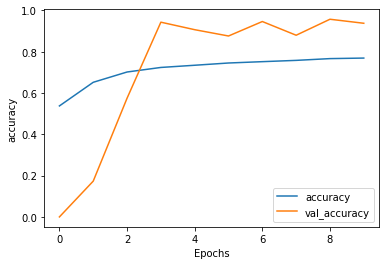

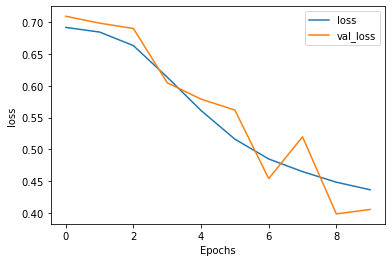

In [75]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [64]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(tweets[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ���
���


In [65]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(5000, 16)


In [66]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, 5000):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [67]:
tweets_teste = np.array(['A nova cédula deverá entrar em circulação a partir do final de agosto.',
                'Não consigo ver nem a de 100, imagina quando vou ter uma de 200..…..mas gostei! =)',
                'É bem ruim, demostra a desvalorização do real.',
                'Vergonha. Decisao Imbecil em Plena Pandemia.',
                'O cachorro-vinagre seria mais fofinho, imagina'])

test_seq = tokenizer.texts_to_sequences(tweets_teste)
test_padded = pad_sequences(test_seq, maxlen=max_len, truncating='post')
print('Padded Sequence: ', test_padded.shape)

Padded Sequence:  (5, 120)


In [68]:
preds = model.predict(test_padded)

predictions = ["Positivo" if i>=0.5 else "Negativo"  for i in preds]

for t, p in zip(tweets_teste, predictions):
    print(t, '\nPredição: ', p, '\n')

A nova cédula deverá entrar em circulação a partir do final de agosto. 
Predição:  Positivo 

Não consigo ver nem a de 100, imagina quando vou ter uma de 200..…..mas gostei! =) 
Predição:  Positivo 

É bem ruim, demostra a desvalorização do real. 
Predição:  Positivo 

Vergonha. Decisao Imbecil em Plena Pandemia. 
Predição:  Positivo 

O cachorro-vinagre seria mais fofinho, imagina 
Predição:  Positivo 

